# Solar Panel Power

In the Notebook below, we will compute the area and shape of the antenna shadow using a simple Monte Carlo technique.

The setup is as follows:

<img src="./animation/setup.png" style="width:600px">

We assume the antennae to be cylinders of radius $r_0=3cm$, at angles $\theta = \theta_ \sim \pi/2$ and $\phi = 0, \pi/2, \pi, 3\pi/2$ starting  from $(0,0,h=0.1)$. The panel is a square surface of side $s=1m$ centered at the origin. 

We assume the positive x-axis to point North, and the positive y-axis to point East. However since we have landing precision of upto $\pm 10^\circ$, we implement it by adding it as an offset to the azimuth. This is effectively rotating the sky instead of rotating the panel. 

###  Algorithm: Monte Carlo Shadow Finder

The essential idea is to compute whether a vector to the sun from a random point on the panel is blocked by the geometry of the antennae. This allows us to freely change the geometry of the problem at a later stage and also simplifies the computations required. 

Assuming the positive x-axis to point North, the positive y-axis points West. Then the Sun at a given Alt-Az corresponds to the polar location 
\begin{equation}
\theta_\odot = \pi/2 - Alt \\ \phi_\odot = 2\pi - Az
\end{equation}

After randomly choosing a point $P(p_x,p_y,0)$ on the panel, we construct the vector to the sun at a given Alt-Az by using its polar location:
\begin{equation}
\vec{S_\odot} = \sin(\theta_\odot) \cos(\phi_\odot) \hat{i} + \sin(\theta_\odot) \sin(\phi_\odot) \hat{j} + \cos(\theta_\odot) \hat{k}
\end{equation}

For the four antennae starting from $(0,0,h=0.1)$, we can define their axis vectors similarly:
\begin{equation}
\vec{A_i} = \sin(\theta_i) \cos(\phi_i) \hat{i} + \sin(\theta_i) \sin(\phi_i) \hat{j} + \cos(\theta_i) \hat{k}
\end{equation}

Now we check the shortest distance $d$ between the sun vector passing through $P(p_x,p_y,0)$, and the axis vector passing through $A(0,0,h)$:
\begin{equation}
d = |(\vec{P}-\vec{A}) \cdot \hat{n} |
\end{equation}
where $\hat{n}$ is the unit vector along $\vec{S_\odot} \times \vec{A_i}$. If this distance is less than the radius of the antenna, we conclude that the sun vector from P is blocked by the antenna.

Thus, for every randomly sampled point, we can check if the point is in shadow (blue) or not (orange), below:


<div>
<img src="animation/lat0.gif" width="900">
</div>


### Implementation:

I. For the given setup, we construct a `SolarCellStringConfiguration` class to describe the solar cell strings on the panel. 

II. For every Sun Alt-Az, we will sample the panel with randomly chosen points and save them as lists `inShadow` or `notInShadow` 

III. Next, we iterate through all `SolarCell`s and calculate their efficiency. Then we can calculate the total instantaneous power output from the panel.

IV. Finally, we integrate the instantaneous power output over time to get the total integrated power output.

### Final Output
<div>
<img src="animation/power_configAzOffset0.17453292519943295_lat30.gif" width="900">
</div>

##### Dependencies

`lusee`, `numpy`, `matplotlib`, `scipy`, `astropy`

In [1]:
import lusee
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.linalg import norm
from scipy.interpolate import interp1d
import os
import astropy.units as units

import MCshadows #all helper functions defined here

### Panel, Antennae, Sun Alt-Az Setup

In [2]:
# set up panel constants
side=1.0 
square_hole_side=0.35

# set up antennae constants
length=6.0; radius=0.015; θ_antenna=np.pi/2.0; ϕ_antenna=0.0*np.pi/180.0
height_above_panel=0.1
antenna_origin_offset=(0.0,0.0,height_above_panel)

# set up solar cell constants
cellsize_y=0.04 
cellsize_x=0.07 

#set up azimuth offset due to landing accuracy
ϕ_landing=10.0*np.pi/180.0

shadow_config_name=f'AzOffset{ϕ_landing}' # appended to the shadow data savename

### Construct String Config for Panel

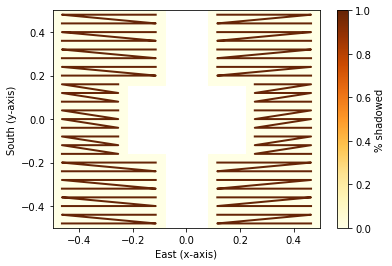

In [3]:
string_config_name='Z_withHole' # appended to power output savename

ncells_y=25
ncells_x=12
ncells_x_hole=8

#bottom third
strings_list3_left=[]
strings_list3_right=[]
for ny in range(0,ncells_y//3,1):
    cells_list2_left=[]
    for nx in range(ncells_x//2):
        bottomleftcorner_x=nx*cellsize_x-0.5 #panel starts at x=-0.5
        bottomleftcorner_y=ny*cellsize_y-0.5 #panel starts at y=-0.5
        actualcellsize_x=min(cellsize_x,0.5-bottomleftcorner_x)
        actualcellsize_y=min(cellsize_y,0.5-bottomleftcorner_y)        
        cell=MCshadows.SolarCell(nx*cellsize_x-0.5,ny*cellsize_y-0.5,actualcellsize_x,actualcellsize_y)
        cells_list2_left.append(cell)
    strings_list3_left.append(cells_list2_left)
    
    cells_list2_right=[]
    for nx in range(ncells_x//2):
        bottomrightcorner_x=0.5-nx*cellsize_x #panel ends at x=0.5
        bottomrightcorner_y=ny*cellsize_y-0.5 #panel starts at y=-0.5
        actualcellsize_x=min(cellsize_x,0.5-bottomleftcorner_x)
        actualcellsize_y=min(cellsize_y,0.5-bottomleftcorner_y)
        cell=MCshadows.SolarCell(0.5-(nx+1)*cellsize_x,ny*cellsize_y-0.5,actualcellsize_x,actualcellsize_y)
        cells_list2_right.append(cell)
    strings_list3_right.append(cells_list2_right)

#middle third, with the hole
for ny in range(ncells_y//3,2*ncells_y//3+1,1):
    cells_list2_left=[]
    for nx in range(ncells_x_hole//2):
        bottomleftcorner_x=nx*cellsize_x-0.5 #panel starts at x=-0.5
        bottomleftcorner_y=ny*cellsize_y-0.5 #panel starts at y=-0.5
        actualcellsize_x=min(cellsize_x,0.5-bottomleftcorner_x)
        actualcellsize_y=min(cellsize_y,0.5-bottomleftcorner_y)        
        cell=MCshadows.SolarCell(nx*cellsize_x-0.5,ny*cellsize_y-0.5,actualcellsize_x,actualcellsize_y)
        cells_list2_left.append(cell)
    strings_list3_left.append(cells_list2_left)
    
    cells_list2_right=[]
    for nx in range(ncells_x_hole//2):
        bottomrightcorner_x=0.5-nx*cellsize_x #panel ends at x=0.5
        bottomrightcorner_y=ny*cellsize_y-0.5 #panel starts at y=-0.5
        actualcellsize_x=min(cellsize_x,0.5-bottomleftcorner_x)
        actualcellsize_y=min(cellsize_y,0.5-bottomleftcorner_y)
        cell=MCshadows.SolarCell(0.5-(nx+1)*cellsize_x,ny*cellsize_y-0.5,actualcellsize_x,actualcellsize_y)
        cells_list2_right.append(cell)
    strings_list3_right.append(cells_list2_right)

#top third
for ny in range(2*ncells_y//3+1,ncells_y,1):
    cells_list2_left=[]
    for nx in range(ncells_x//2):
        bottomleftcorner_x=nx*cellsize_x-0.5 #panel starts at x=-0.5
        bottomleftcorner_y=ny*cellsize_y-0.5 #panel starts at y=-0.5
        actualcellsize_x=min(cellsize_x,0.5-bottomleftcorner_x)
        actualcellsize_y=min(cellsize_y,0.5-bottomleftcorner_y)        
        cell=MCshadows.SolarCell(nx*cellsize_x-0.5,ny*cellsize_y-0.5,actualcellsize_x,actualcellsize_y)
        cells_list2_left.append(cell)
    strings_list3_left.append(cells_list2_left)
    
    cells_list2_right=[]
    for nx in range(ncells_x//2):
        bottomrightcorner_x=0.5-nx*cellsize_x #panel ends at x=0.5
        bottomrightcorner_y=ny*cellsize_y-0.5 #panel starts at y=-0.5
        actualcellsize_x=min(cellsize_x,0.5-bottomleftcorner_x)
        actualcellsize_y=min(cellsize_y,0.5-bottomleftcorner_y)
        cell=MCshadows.SolarCell(0.5-(nx+1)*cellsize_x,ny*cellsize_y-0.5,actualcellsize_x,actualcellsize_y)
        cells_list2_right.append(cell)
    strings_list3_right.append(cells_list2_right)

    
#connect the strings and construct the full config
strings_list3=[]
for ny in range(0,(ncells_y//3),2):
    strings_list3.append(MCshadows.SolarCellString(strings_list3_left[ny]+strings_list3_left[ny+1]))
    strings_list3.append(MCshadows.SolarCellString(strings_list3_right[ny]+strings_list3_right[ny+1]))
for ny in range((ncells_y//3),2*(ncells_y//3)+1,3):
    strings_list3.append(MCshadows.SolarCellString(strings_list3_left[ny]+strings_list3_left[ny+1]+strings_list3_left[ny+2]))
    strings_list3.append(MCshadows.SolarCellString(strings_list3_right[ny]+strings_list3_right[ny+1]+strings_list3_right[ny+2]))
for ny in range(2*(ncells_y//3)+1,ncells_y,2):
    strings_list3.append(MCshadows.SolarCellString(strings_list3_left[ny]+strings_list3_left[ny+1]))
    strings_list3.append(MCshadows.SolarCellString(strings_list3_right[ny]+strings_list3_right[ny+1]))

config=MCshadows.SolarCellStringConfiguration(name=string_config_name,strings_list=strings_list3)
config.plot()

### Run Monte Carlo Shadow Finder

In [4]:
# get sun alt-az 

lat=30
night = 2500
print(f'calculating Sun AltAz for night={night} and lat={lat}')

obs = lusee.LObservation(night, lun_lat_deg=lat, lun_long_deg=0,  deltaT_sec=15*60)
temp_alt,temp_az=obs.get_track_solar('sun')
above_horizon=np.where(temp_alt>0)
sun_alt=temp_alt[above_horizon]
sun_az=temp_az[above_horizon]
# add ϕ_landing offset for azimuth.
# this is effectively rotating the frame,
# instead of rotating the panel
print(f'add landing offset of {ϕ_landing} radians')
az_offset=ϕ_landing*np.ones_like(sun_az) 
sun_az=sun_az+az_offset
npositions=len(sun_alt)

# get time difference array to use to calculate integrated power
times=obs.times[above_horizon]
δtimes=times[1:]-times[:-1]
days=[t-times[0] for t in times]
days=[d.to('day').value for d in days]

np.savetxt(f'./output/sun_AltAz_night{night}_lat{lat}_AzOffset{ϕ_landing}.txt',np.column_stack([sun_alt,sun_az]))
print('done')

calculating Sun AltAz for night=2500 and lat=30
done


In [5]:
## Est. runtime ~1 hour on single core of i7-3rd Gen with npositions=1415, nsamples=5000

print('now calculate shadow samples and power output...')
shadow_area=[]
power_output=[]
for i,altaz in enumerate(zip(sun_alt,sun_az)):
    #percent progress
    if 10*i//npositions!=10*(i-1)//npositions: print(f'{100*i//npositions}% completed')
    
    #calculate if inShadow or notInShadow
    sun_vec=MCshadows.sun_vector(*altaz)
    inShadow, notInShadow=MCshadows.monte_carϕhadow(sun_vec, side, radius, θ_antenna, ϕ_antenna, nsamples=5000)
    MCshadows.save_shadow_samples(shadow_config_name, night, lat,*altaz,inShadow,notInShadow)
    
    #calculate shadow area
    area=len(inShadow)/(len(inShadow)+len(notInShadow))
    shadow_area.append(area)
    
    #compute cells in shadow
    config.update_shadow_cells(inShadow,notInShadow)
    
    #compute string efficiencies
    config.update_efficiency_strings()
    
    #compute power output
    poutput=config.power_output(altaz[0])
    power_output.append(poutput)

#save files
np.savetxt(f'./output/shadow_area_config{shadow_config_name}_night{night}_lat{lat}.txt', shadow_area)
np.savetxt(f'./output/power_output_stringconfig{config.name}_shadowconfig{shadow_config_name}_night{night}_lat{lat}_AzOffset{ϕ_landing}.txt', power_output)
print('done!')

now calculate shadow samples and power output...
0% completed
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
done!


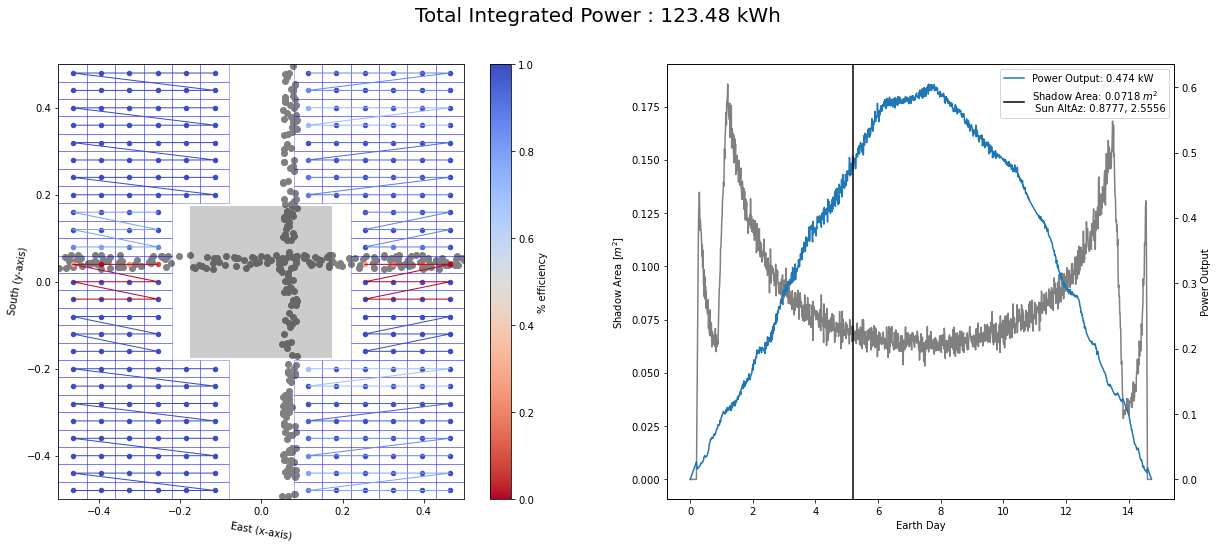

In [6]:
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# If you have run and saved all samples, you can change these values to see individual frames
sun_altaz_index=500
shadow_config=f'AzOffset{ϕ_landing}'
string_config=f'Z_withHole'
#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# for sun_altaz_index in range(0,len(sun_alt),20):
fig,ax=plt.subplots(1,2,figsize=(20,8))

inShadow, notInShadow = MCshadows.load_shadow_samples(shadow_config, night,lat,sun_alt[sun_altaz_index],sun_az[sun_altaz_index])
if len(inShadow)!=0: ax[0].scatter(*inShadow.T,color='gray')

config.update_shadow_cells(inShadow,notInShadow)
config.update_efficiency_strings()

for string in config.strings:
    xy=[cell.center for cell in string.cells]
    ax[0].plot(*zip(*xy), color=matplotlib.cm.coolwarm_r(string.efficiency), lw=1.0)
    for cell in string.cells:
        scatter=ax[0].scatter(cell.center[0],cell.center[1], c=1-cell.shadowed if cell.shadowed is not None else 0.0,
                              norm=matplotlib.colors.Normalize(vmin=0.0,vmax=1.0),
                              cmap='coolwarm_r', marker='o', s=20)

        ax[0].add_patch(plt.Rectangle(xy=(cell.center[0]-cellsize_x/2,cell.center[1]-cellsize_y/2), width=cellsize_x, height=cellsize_y, 
                                      linewidth=1, color='blue', fill=False, alpha=0.3))
ax[0].add_patch(plt.Rectangle((-square_hole_side/2,-square_hole_side/2),square_hole_side,square_hole_side, fc='k', alpha=0.2))
fig.colorbar(scatter, ax=ax[0], label='% efficiency')
ax[0].set_xlim(-0.5,0.5)
ax[0].set_ylim(-0.5,0.5)
ax[0].set_xlabel('East (x-axis)', rotation=-ϕ_landing*180/np.pi)
ax[0].set_ylabel('South (y-axis)', rotation=-ϕ_landing*180/np.pi+90)



# area function
shadow_area=np.loadtxt(f'./output/shadow_area_config{shadow_config}_night{night}_lat{lat}.txt')
shadow_area_function=interp1d(range(len(shadow_area)),shadow_area)
ax[1].plot(days,shadow_area_function(range(len(shadow_area))), color='gray')
ax[1].set_ylabel('Shadow Area $[m^2]$')
ax[1].set_xlabel('Earth Day')

# power output
panel_power_output=np.loadtxt(f'./output/power_output_stringconfig{config.name}_shadowconfig{shadow_config}_night{night}_lat{lat}_AzOffset{ϕ_landing}.txt')
panel_power_output_function=interp1d(range(len(panel_power_output)),panel_power_output)
midpt_panel_power_output=(panel_power_output[1:]+panel_power_output[:-1])/2
integrated_power=sum([m*units.kW*dt.to('hour') for m,dt in zip(midpt_panel_power_output,δtimes)])
fig.suptitle(f'Total Integrated Power : {integrated_power.value:.2f} kWh',size=20)


ax3=ax[1].twinx()
ax3.set_ylabel('Power Output')
ax3.plot(days, panel_power_output_function(range(len(panel_power_output))), label=f'Power Output: {panel_power_output[sun_altaz_index]:1.3f} kW') 
ax3.axvline(x=days[sun_altaz_index], color='k', label=f'Shadow Area: {shadow_area_function(sun_altaz_index)} $m^2$ \n Sun AltAz: {sun_alt[sun_altaz_index]:1.4f}, {sun_az[sun_altaz_index]:1.4f}')
ax3.legend()

plt.show()
#     plt.savefig(f'animation/{config.name}/power_lat{lat}_altazindex{sun_altaz_index:04d}.png')
#     plt.close(fig)